Adopted from https://www.kaggle.com/code/aymenmodel/genre-based-song-lyrics-generator

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import kagglehub
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/genius-song-lyrics-with-language-information/song_lyrics.csv")
df.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en


# Data Preprocessing 

In [3]:
# Check for null values in each column
null_counts = df.isnull().sum()
print(null_counts)

title               188
tag                   0
artist                0
year                  0
views                 0
features              0
lyrics                0
id                    0
language_cld3     90966
language_ft      134322
language         226918
dtype: int64


In [4]:
df = df.dropna(subset=['title'])

In [5]:
# Filter rows where the 'language' column is 'en'
df_clean = df[df['language'] == 'en']

#check 
en = df_clean['language'] == 'en'
other = df_clean['language'] != 'en'

print("english lyrics:", en.sum())
print("other language lyrics:", other.sum())
null_counts_lang = df_clean['language'].isnull().sum()
print("null language values:",null_counts_lang)

english lyrics: 3374071
other language lyrics: 0
null language values: 0


In [6]:
# Check for null values in each column
null_counts = df_clean.isnull().sum()
print(null_counts)

title            0
tag              0
artist           0
year             0
views            0
features         0
lyrics           0
id               0
language_cld3    0
language_ft      0
language         0
dtype: int64


In [7]:
#drop irrelevant columns 
columns_to_drop = ['artist', 'views', 'features', 'language', 'language_cld3', 'language_ft', 'id','year'] 
df_clean = df_clean.drop(columns=columns_to_drop)
df_clean.head()

,title,tag,lyrics
0,Killa Cam,rap,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki..."
1,Can I Live,rap,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,..."
2,Forgive Me Father,rap,Maybe cause I'm eatin\nAnd these bastards fien...
3,Down and Out,rap,[Produced by Kanye West and Brian Miller]\n\n[...
4,Fly In,rap,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."


In [8]:
df_clean.head()
num_rows_before = df.shape[0]
num_rows = df_clean.shape[0]
print(f"Number of rows in the dataset before: {num_rows_before}")
print(f"Number of rows in the dataset: {num_rows}")

Number of rows in the dataset before: 5134668
Number of rows in the dataset: 3374071


In [9]:
pd.set_option('display.max_colwidth', None)

# Get a random sample of lyrics
print(df_clean['lyrics'].sample(1).iloc[0])

# Optionally reset column width back to default (optional)
pd.reset_option('display.max_colwidth')

[Verse 1]
You confessed one day to have been a snake and deceiver
But when your moment came, to shed that skin
You just slithered away
You just slithered away

[Verse 2]
Crystal clear to us all, when you say "We all want the same thing"
That you don't, you want the bigger piece and the praise
There are those who have seen, and those soon to beware
What your smoke is concealing
Just a trail of bones, atop a lemming's hill
All fallen prey
All fallen prey
All fallen prey

[Chorus]
To the liar
Not a saint
Not a martyr
Just a snake
And a liar
[Verse 3]
We used to believe, when you'd say
"We're all in this together"
No more, we all see
Now the mirror is broken, we all know
What your spell was concealing
Just hollow eyes, a stolen crown
But not a king
No, not a king
No, not a king

[Chorus]
Just the liar
Not a saint
Not a martyr
Just a snake
And a liar


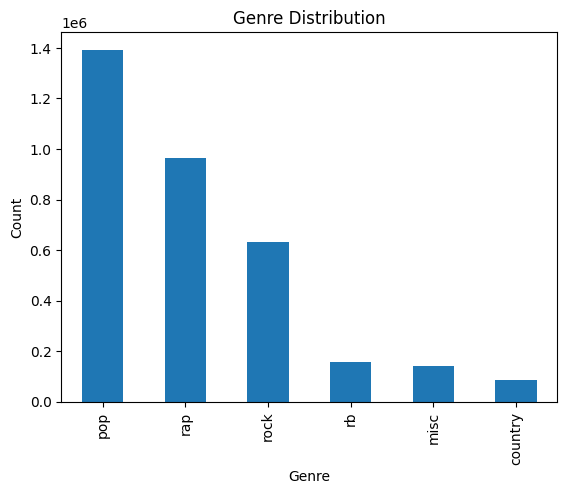

In [10]:
# distribution of genre 
df_clean['tag'].value_counts()
genre_distribution = df_clean['tag'].value_counts()
genre_distribution.plot(kind='bar', title='Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


In [11]:
genre_distribution = df_clean['tag'].value_counts()
print(genre_distribution)

tag
pop        1393536
rap         964538
rock        633287
rb          155075
misc        140977
country      86658
Name: count, dtype: int64


# Downsampling Dominant Genres

In [12]:
# Determine the maximum samples to retain for each genre
max_samples = min(df_clean['tag'].value_counts())

# Downsample each genre
df_clean = df_clean.groupby('tag').apply(lambda x: x.sample(max_samples)).reset_index(drop=True)
print(df_clean['tag'].value_counts())

tag
country    86658
misc       86658
pop        86658
rap        86658
rb         86658
rock       86658
Name: count, dtype: int64


/tmp/ipykernel_30/564001104.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('tag').apply(lambda x: x.sample(max_samples)).reset_index(drop=True)


In [14]:
df_clean.to_csv('reduced_lyrics.csv', index=False)